In [1]:
!/opt/bin/nvidia-smi
!nvcc --version

/bin/sh: 1: /opt/bin/nvidia-smi: not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

In [4]:
!wget 'https://storage.googleapis.com/sherlock_datasets/CASIA-V2.zip'

--2020-04-11 21:35:39--  https://storage.googleapis.com/sherlock_datasets/CASIA-V2.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2738490556 (2.5G) [application/zip]
Saving to: ‘CASIA-V2.zip’

CASIA-V2.zip        100%[===================>]   2.55G   142MB/s    in 18s     

2020-04-11 21:35:57 (149 MB/s) - ‘CASIA-V2.zip’ saved [2738490556/2738490556]



In [0]:
!unzip -o -q CASIA-V2.zip

In [0]:
def exportStageTo(learn, path):
    learn.export()
    copyfile(path/'export.pkl', path/'export-ela.pkl')

def restoreStageFrom(path):
    # Restore a backup
    copyfile(path/'export-ela.pkl', path/'export.pkl')
    return load_learner(path)

In [13]:
path = Path("/home/tiago4k_gmail_com/CASIA-V2"); path

PosixPath('/home/tiago4k_gmail_com/CASIA-V2')

In [0]:
path_to_test = Path("/home/tiago4k_gmail_com/CASIA-V2/Test")
test = ImageList.from_folder(path_to_test)

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)

In [0]:
# Batch Size
bs = 64
# Image size, 448x448
size = 448
data = ImageDataBunch.from_folder(path, train='Train', valid='Valid', 
                                  ds_tfms = tfms, size=size, bs=bs)

data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

In [17]:
data.show_batch(rows=5, figsize=(15,15))

Output hidden; open in https://colab.research.google.com to view.

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/tiago4k_gmail_com/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [19]:
learn.fit_one_cycle(10, callbacks=[SaveModelCallback(learn, every='epoch', 
                                                     monitor='accuracy', 
                                                     name='casia-1')])
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.999441,0.673558,0.316839,0.683161,01:11
1,0.778603,0.591198,0.312515,0.687485,01:07
2,0.640657,0.593123,0.312035,0.687965,01:07
3,0.595912,0.564585,0.285611,0.714389,01:08
4,0.572752,0.538087,0.269998,0.730002,01:07
5,0.540078,0.525872,0.262071,0.737929,01:07
6,0.514714,0.500876,0.260629,0.739371,01:07
7,0.485259,0.489279,0.239010,0.760990,01:07
8,0.466032,0.483267,0.235647,0.764353,01:07
9,0.463703,0.478296,0.232525,0.767475,01:07


In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

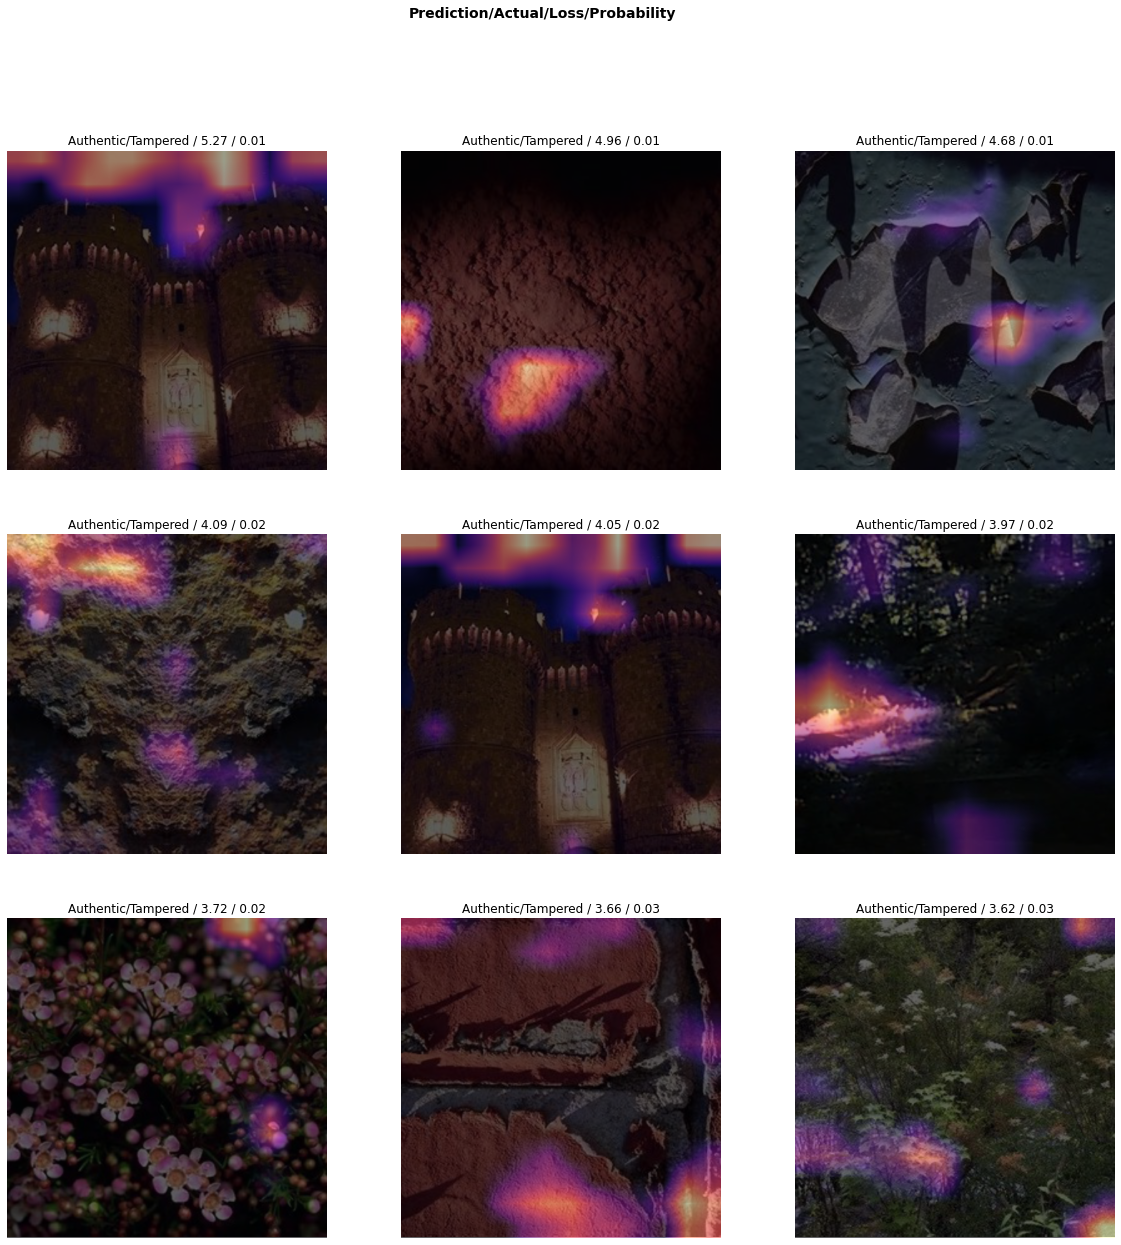

In [28]:
interp.plot_top_losses(9, figsize=(20,20), heatmap=True)

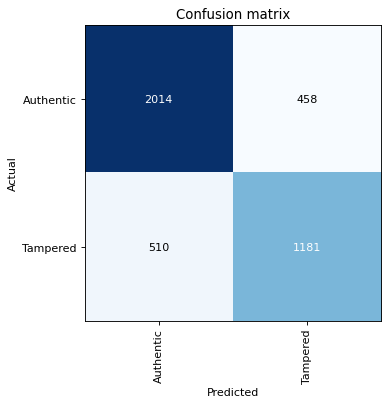

In [26]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

In [0]:
interp.plot_multi_top_losses(6, figsize=(20,20))

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


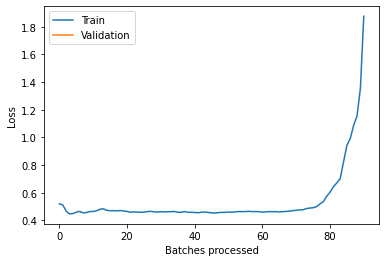

In [32]:
learn.lr_find()
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 8.32E-07


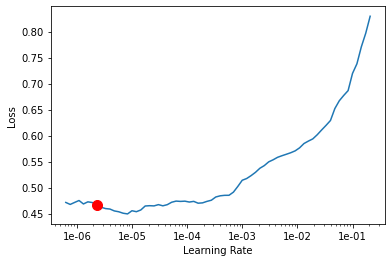

In [37]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [38]:
learn.unfreeze()

learn.fit_one_cycle(30, max_lr=slice(1e-5,1e-6), 
                    callbacks=[SaveModelCallback(learn, 
                                                 every='epoch', 
                                                 monitor='accuracy', 
                                                 name='casia')])
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.457733,0.483014,0.238049,0.761950,01:28
1,0.464150,0.473108,0.228681,0.771319,01:28
2,0.462386,0.475824,0.233726,0.766274,01:28
3,0.450829,0.467321,0.225078,0.774922,01:28
4,0.451697,0.463708,0.222676,0.777324,01:28
5,0.439597,0.452931,0.216911,0.783089,01:28
6,0.433948,0.455089,0.211866,0.788134,01:28
7,0.429546,0.441544,0.207302,0.792698,01:28
8,0.417053,0.445775,0.216430,0.783570,01:28
9,0.408882,0.432048,0.208744,0.791256,01:28


In [39]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

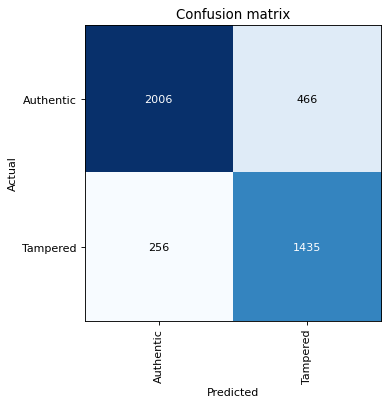

In [40]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

Get Predictions and accuracy on the test dataset

In [0]:
learn = load_learner(path)

In [42]:
path = '/home/tiago4k_gmail_com/CASIA-V2/Test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)
    
            # if conf >=65:
            #     print('Predicted: {} ------ Confidence: {:.3f}% ------ Actual: {}'.format(pred_class, conf, folder))
            
            

/home/tiago4k_gmail_com/CASIA-V2/Test/Tampered/
/home/tiago4k_gmail_com/CASIA-V2/Test/Authentic/


In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [44]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
402/502. Accuracy = 80.08%
Images Classified As Tampered
286/344. Accuracy = 83.14%


In [45]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 82.582%


In [0]:
learn.export()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


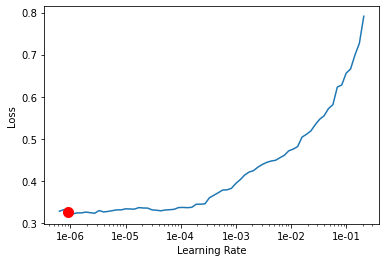

In [47]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

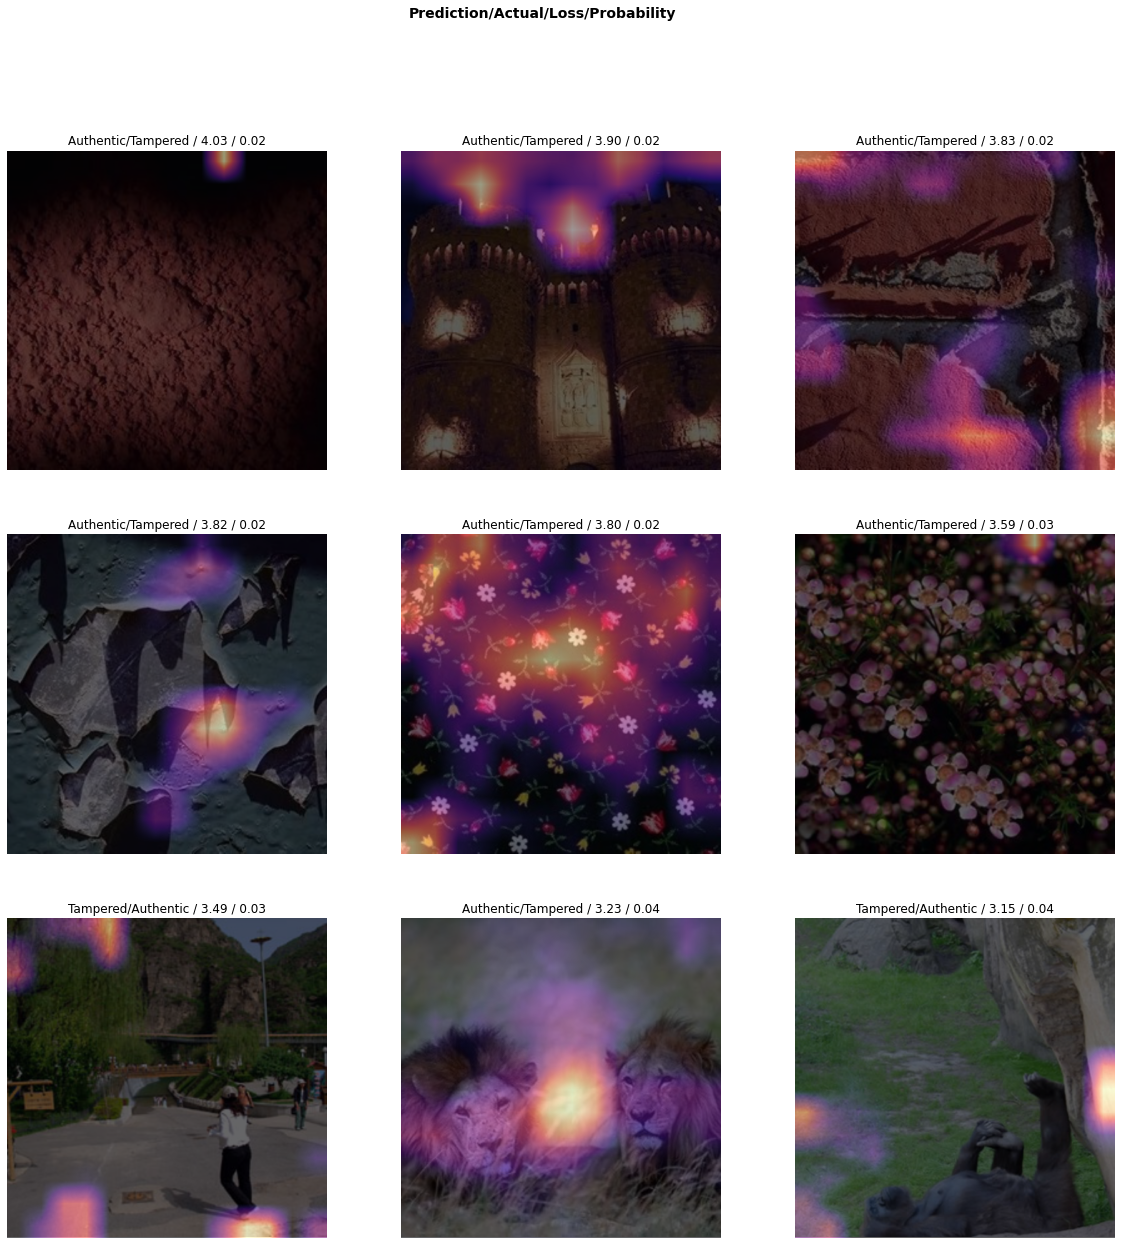

In [48]:
interp.plot_top_losses(9, figsize=(20,20), heatmap=True)